<a href="https://colab.research.google.com/github/shraddhapai/fastai/blob/main/Jazz_Goddess_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

# fastai applications - quick start

fastai's applications all use the same basic steps and code:

- Create appropriate `DataLoaders`
- Create a `Learner`
- Call a *fit* method
- Make predictions or view results.

In this quick start, we'll show these steps for a wide range of difference applications and datasets. As you'll see, the code in each case is extremely similar, despite the very different models and data being used.

## Computer vision classification

The code below does the following things:

1. A dataset called the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) that contains 7,349 images of cats and dogs from 37 different breeds will be downloaded from the fast.ai datasets collection to the GPU server you are using, and will then be extracted.
2. A *pretrained model* that has already been trained on 1.3 million images, using a competition-winning model will be downloaded from the internet.
3. The pretrained model will be *fine-tuned* using the latest advances in transfer learning, to create a model that is specially customized for recognizing dogs and cats.

The first two steps only need to be run once. If you run it again, it will use the dataset and model that have already been downloaded, rather than downloading them again.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

# authenticate Google drive
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()

#drive = GoogleDrive(gauth)
#local_expanded_path = os.path.expanduser('~/data')
#print(local_expanded_path)

# get label from filename
def singerLabel(x): 
  if ('EF_' in x): 
    return 'Ella'
  elif ('NS_' in x): 
    return 'Nina'
  elif ('SV_' in x):
    return 'Sarah'
  else: 
    return 'Billie'

path=Path('/content/drive/My Drive/Courses/FASTAI/jazz_goddesses')
x = get_image_files(path)
print(x)
dls=ImageDataLoaders.from_name_func(
    path, get_image_files(path),valid_pct=0.2,seed=42,
    label_func=singerLabel, item_tfms=Resize(224)
)

learn=cnn_learner(dls,resnet34, metrics=error_rate)
learn.fine_tune(1)

# get image folder
# jazz = drive.ListFile({'q': "'18RJgGAZzTDFCXkw67hDgEz5Hm9XaUP7L' in parents"}).GetList()
# path = Path('https://drive.google.com/drive/folders/18RJgGAZzTDFCXkw67hDgEz5Hm9XaUP7L?usp=sharing')
# imgFiles =[]
# for cur in jazz:
#   imgFiles.append(Path(cur[]))

#print(imgFiles)





(#276) [Path('/content/drive/My Drive/Courses/FASTAI/jazz_goddesses/images/EF_62.a19l4hcbgxl._cr0,0,3840,2880_._sl1000_.jpg'),Path('/content/drive/My Drive/Courses/FASTAI/jazz_goddesses/images/SV_50.vaughan-1.jpg'),Path('/content/drive/My Drive/Courses/FASTAI/jazz_goddesses/images/SV_22.hq720.jpg'),Path('/content/drive/My Drive/Courses/FASTAI/jazz_goddesses/images/EF_57.ella_fitzgerald_gettyimages-91150202-h_2020_0.jpg'),Path('/content/drive/My Drive/Courses/FASTAI/jazz_goddesses/images/SV_54.r-12752694-1541281946-7909.jpeg.jpg'),Path('/content/drive/My Drive/Courses/FASTAI/jazz_goddesses/images/NS_87.gettyimages-2667899.ninasimone.jpg'),Path('/content/drive/My Drive/Courses/FASTAI/jazz_goddesses/images/SV_62.chinese_wedding_calgary-2.jpg'),Path('/content/drive/My Drive/Courses/FASTAI/jazz_goddesses/images/EF_13.63aiqvwiduylmyi5h6qxzd5wn4.jpg'),Path('/content/drive/My Drive/Courses/FASTAI/jazz_goddesses/images/EF_24.bn-tc561_ella04_m_20170424144447.jpg'),Path('/content/drive/My Drive/C

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.893821,1.710200,0.654545,01:39


epoch,train_loss,valid_loss,error_rate,time
0,1.397940,1.095890,0.436364,01:42


Now we examine the confusion matrix to understand where the model goes wrong. 

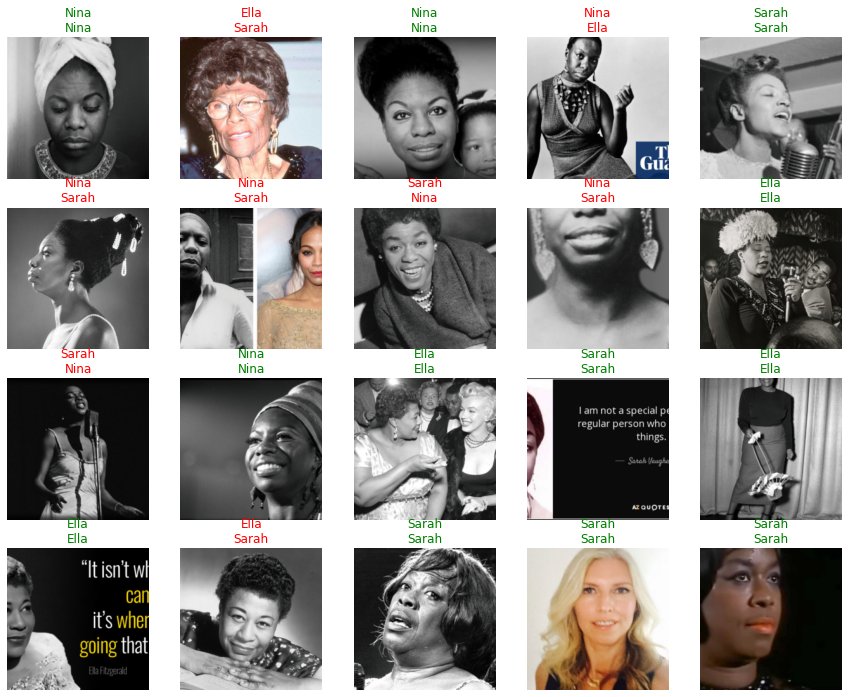

In [ ]:
learn.show_results(max_n=20)

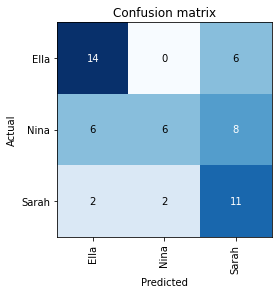

In [ ]:
# interpreter to replot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

We use the `plot_top_losses()` function to see which images the classifier misclassifies with... most confidence?

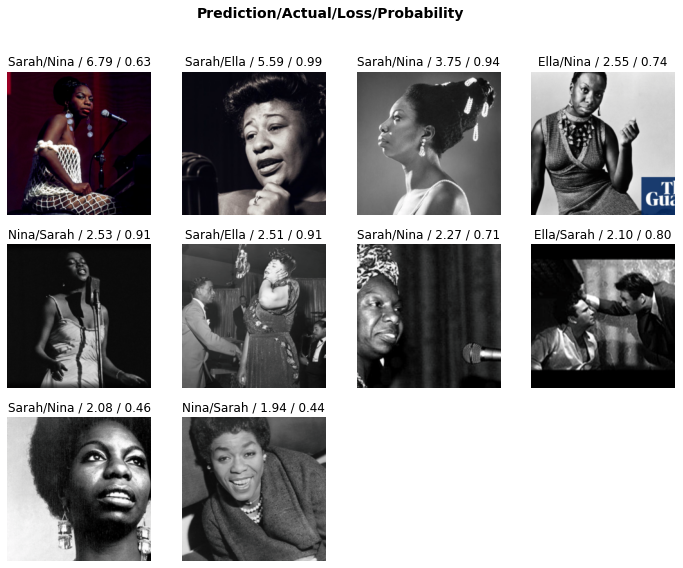

In [ ]:
interp.plot_top_losses(10)

Now we take an arbitrary image from our training set (cheating) and ask if the classifier can predict it.

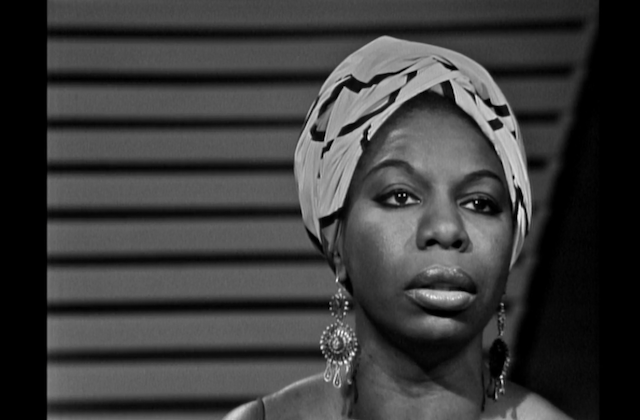

In [ ]:

img = PILImage.create("/content/drive/My Drive/Courses/FASTAI/Nina Simone/55.coates-nina-simone-3-21-16.png")
img

Now classify.

In [ ]:
who,_,probs = learn.predict(img)
print(f"Which jazz goddess is this?: {who}.")
print(f"Probability it's Nina: {probs[1].item():.6f}")

Which jazz goddess is this?: Nina.
Probability it's Nina: 0.563530


### Computer vision segmentation

Here is how we can train a segmentation model with fastai, using a subset of the [*Camvid* dataset](http://www0.cs.ucl.ac.uk/staff/G.Brostow/papers/Brostow_2009-PRL.pdf):

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

epoch,train_loss,valid_loss,time
0,2.882460,2.096923,00:03


epoch,train_loss,valid_loss,time
0,1.602270,1.543582,00:02
1,1.417732,1.225782,00:02
2,1.307454,1.071090,00:02
3,1.170338,0.884501,00:02
4,1.047036,0.799820,00:02
5,0.947965,0.754801,00:02
6,0.868178,0.728161,00:02
7,0.804939,0.720942,00:02


We can visualize how well it achieved its task, by asking the model to color-code each pixel of an image.

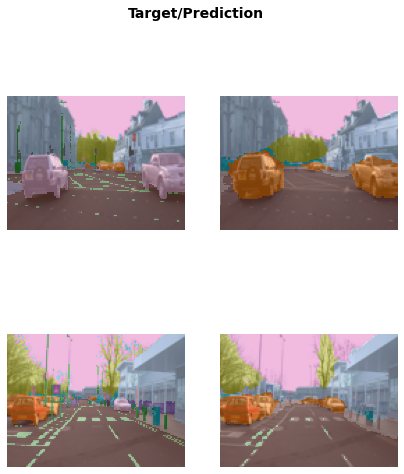

In [ ]:
learn.show_results(max_n=6, figsize=(7,8))

## Natural language processing

Here is all of the code necessary to train a model that can classify the sentiment of a movie review better than anything that existed in the world just five years ago:

In [ ]:
dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.594912,0.407416,0.823640,01:35


epoch,train_loss,valid_loss,accuracy,time
0,0.268259,0.316242,0.876000,03:03
1,0.184861,0.246242,0.898080,03:10
2,0.136392,0.220086,0.918200,03:16
3,0.106423,0.191092,0.931360,03:15


Predictions are done with `predict`, as for computer vision:

In [ ]:
learn.predict("I really liked that movie!")

('pos', tensor(1), tensor([0.0041, 0.9959]))

## Tabular

Building models from plain *tabular* data is done using the same basic steps as the previous models. Here is the code necessary to train a model that will predict whether a person is a high-income earner, based on their socioeconomic background:

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.372298,0.359698,0.829392,00:06
1,0.357530,0.349440,0.837377,00:06


## Recommendation systems

Recommendation systems are very important, particularly in e-commerce. Companies like Amazon and Netflix try hard to recommend products or movies that users might like. Here's how to train a model that will predict movies people might like, based on their previous viewing habits, using the [MovieLens dataset](https://doi.org/10.1145/2827872):

In [ ]:
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(6)

epoch,train_loss,valid_loss,time
0,1.497551,1.435720,00:00


epoch,train_loss,valid_loss,time
0,1.332337,1.351769,00:00
1,1.180177,1.046801,00:00
2,0.913091,0.799319,00:00
3,0.749806,0.731218,00:00
4,0.686577,0.715372,00:00
5,0.665683,0.713309,00:00


We can use the same `show_results` call we saw earlier to view a few examples of user and movie IDs, actual ratings, and predictions:

In [ ]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,5.0,3.0,2.0,3.985477
1,1.0,62.0,4.0,3.629225
2,91.0,81.0,1.0,3.476280
3,48.0,26.0,2.0,4.043919
4,75.0,54.0,3.0,4.023057
5,42.0,22.0,3.0,3.509050
6,40.0,59.0,4.0,3.686552
7,63.0,77.0,3.0,2.862713
8,32.0,61.0,4.0,4.356578
